In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
import warnings
from matplotlib import pyplot as plt 
import seaborn as sns
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_csv('BTC_Data.csv')
data = data.iloc[:,2:9]
data

,Open,High,Low,Close,Adj Close,Volume
0,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072
...,...,...,...,...,...,...
1687,24318.316406,25135.589844,23839.775391,24136.972656,24136.972656,35123501685
1688,24126.136719,24228.416016,23733.500000,23883.291016,23883.291016,27753685646
1689,23881.316406,24407.058594,23243.353516,23335.998047,23335.998047,30931623076
1690,23341.039062,23563.832031,23177.601562,23212.738281,23212.738281,23747613147


In [3]:
df = pd.DataFrame(data)
nd_column = df.pop('Close')
df.pop('Adj Close')
df.insert(4, 'Close',nd_column)
df.head()

,Open,High,Low,Volume,Close
0,14112.200195,14112.200195,13154.700195,10291200000,13657.200195
1,13625.000000,15444.599609,13163.599609,16846600192,14982.099609
2,14978.200195,15572.799805,14844.500000,16871900160,15201.000000
3,15270.700195,15739.700195,14522.200195,21783199744,15599.200195
4,15477.200195,17705.199219,15202.799805,23840899072,17429.500000


In [4]:
X = df.iloc[:,0:4]
y = df.iloc[:,-1:]

In [5]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 4.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.2 MB/s 


In [6]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
#ADF Test
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(); print(f'ADF Statistic: {result[0]}')
    print();  print(f'n_lags: {result[1]}')
    print();  print(f'p-value: {result[1]}')

    print(); print('Critial Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')   

adf_test(y)


ADF Statistic: -1.3290490163755042

n_lags: 0.6157798146087734

p-value: 0.6157798146087734

Critial Values:
   1%, -3.43427885313169
   5%, -2.863275365507293
   10%, -2.5676938662645394


In [8]:
#KPSS Test

from statsmodels.tsa.stattools import kpss

def kpss_test(series, **kw):    
    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    
    # Format Output
    print(); print(f'KPSS Statistic: {statistic}')
    print(); print(f'p-value: {p_value}')
    print(); print(f'num lags: {n_lags}')
    print(); print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    
kpss_test(y)


KPSS Statistic: 4.2304910282419925

p-value: 0.01

num lags: 26

Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


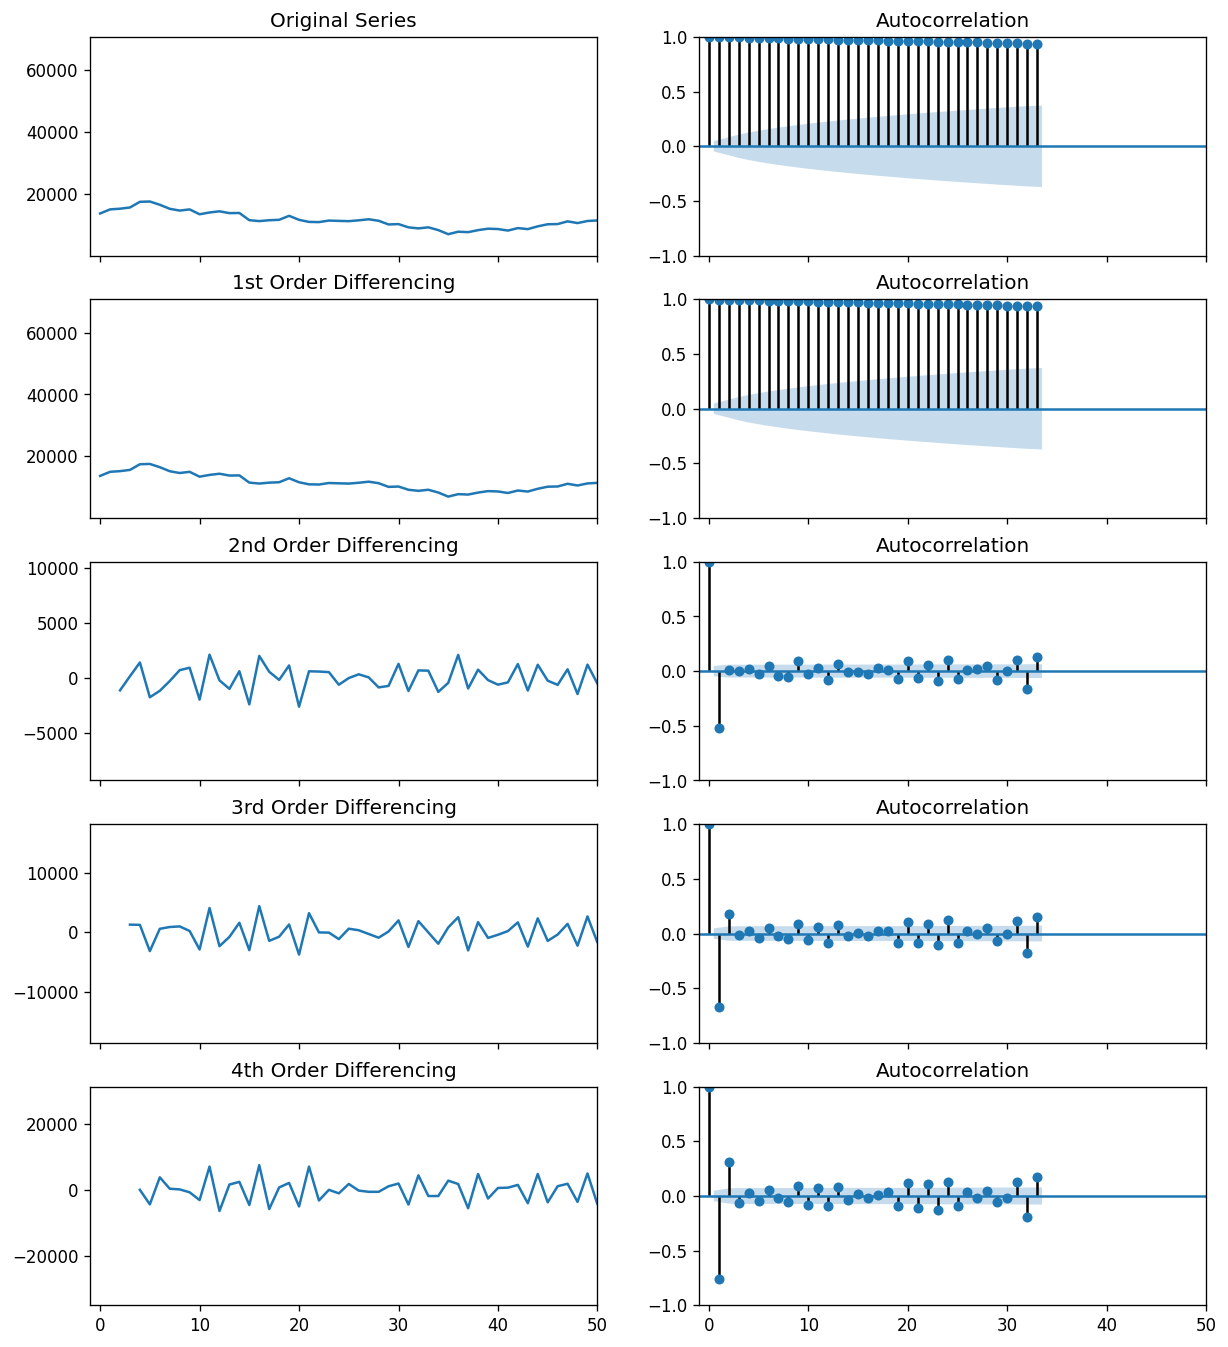

In [9]:
#Finding order of differncing d in ARIMA Model

plt.rcParams.update({'figure.figsize':(12,14), 'figure.dpi':120})

y.reset_index(drop=True, inplace=True)

# Original Series
fig, axes = plt.subplots(5, 2, sharex=True)
axes[0, 0].plot(y.values); axes[0, 0].set_title('Original Series')
plot_acf(y.values, ax=axes[0, 1])

# 1st Differencing
y1 = y.diff()
y1 = y.dropna()
axes[1, 0].plot(y1); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(y1.dropna(), ax=axes[1, 1])

# 2nd Differencing
y2 = y.diff().diff()
axes[2, 0].plot(y2); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(y2.dropna(), ax=axes[2, 1])

# 3rd Differencing
y3 = y.diff().diff().diff()
axes[3, 0].plot(y3); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(y3.dropna(), ax=axes[3, 1])

# 3rd Differencing
y4 = y.diff().diff().diff().diff()
axes[4, 0].plot(y4); axes[4, 0].set_title('4th Order Differencing')
plot_acf(y4.dropna(), ax=axes[4, 1])
plt.xlim(-1,50)
plt.show()

In [11]:
#ADF and KPSS Stats for the differenced data

warnings.filterwarnings("ignore")


print("4th Diffencing: ")
print("---------------------------------------------")
y4 = y4.diff().diff().diff().diff()
adf_test(y4.dropna())
print(); print("---------------------------------------------")
kpss_test(y4.dropna())
print(); print("---------------------------------------------")

4th Diffencing: 
---------------------------------------------

ADF Statistic: -37.31443188467857

n_lags: 0.0

p-value: 0.0

Critial Values:
   1%, -3.4343097809950986
   5%, -2.8632890172254655
   10%, -2.5677011356149544

---------------------------------------------

KPSS Statistic: 0.021382801097659

p-value: 0.1

num lags: 69

Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739

---------------------------------------------


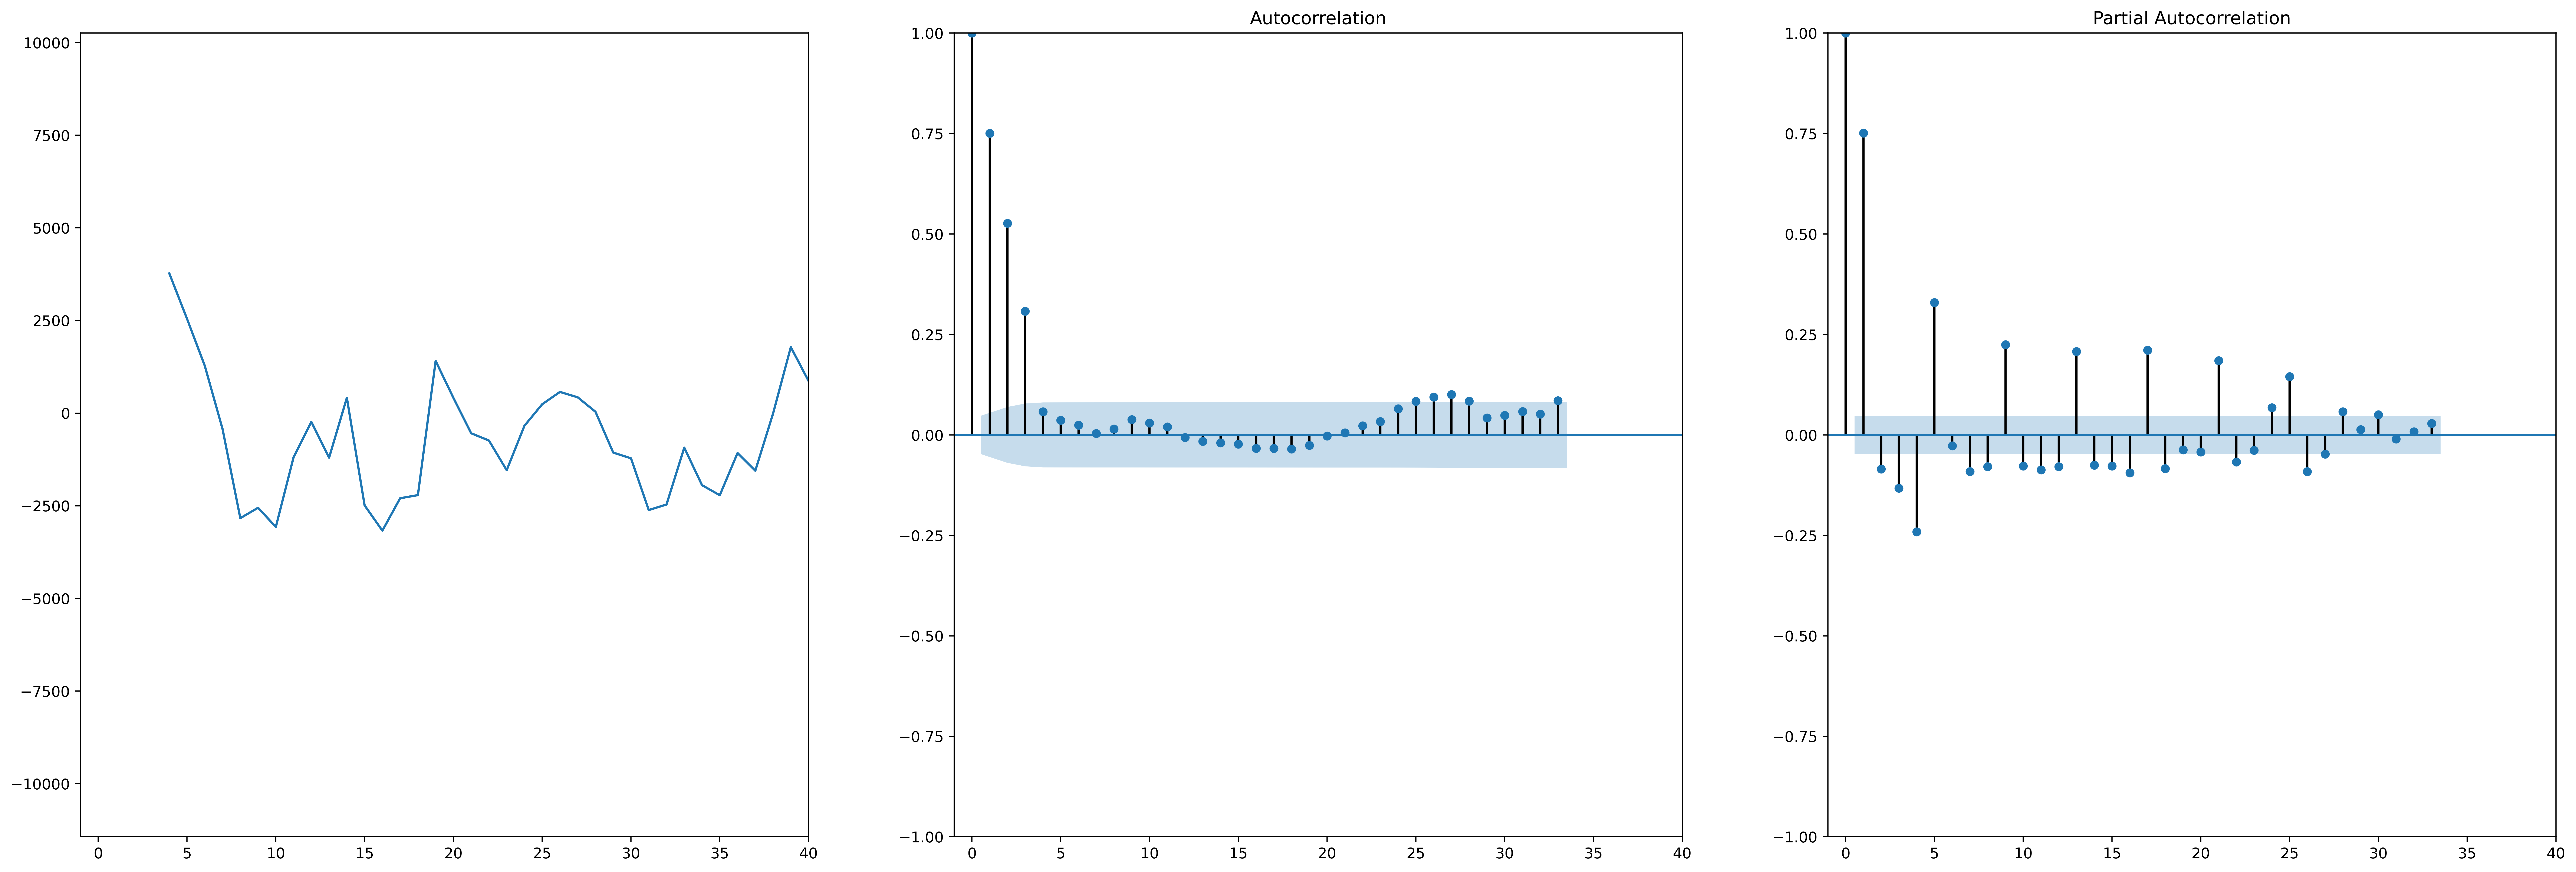

In [12]:
#plotting the ACF and PACF graphs
plt.rcParams.update({'figure.figsize':(30,10), 'figure.dpi':500})
fig, axes = plt.subplots(1, 3, sharex=True)

Y1_Diff = y.diff(periods=4)
axes[0].plot(Y1_Diff.values)
plot_acf(Y1_Diff.dropna().values, ax=axes[1])
plot_pacf(Y1_Diff.dropna().values, ax=axes[2])
plt.xlim(-1,40)
plt.show()

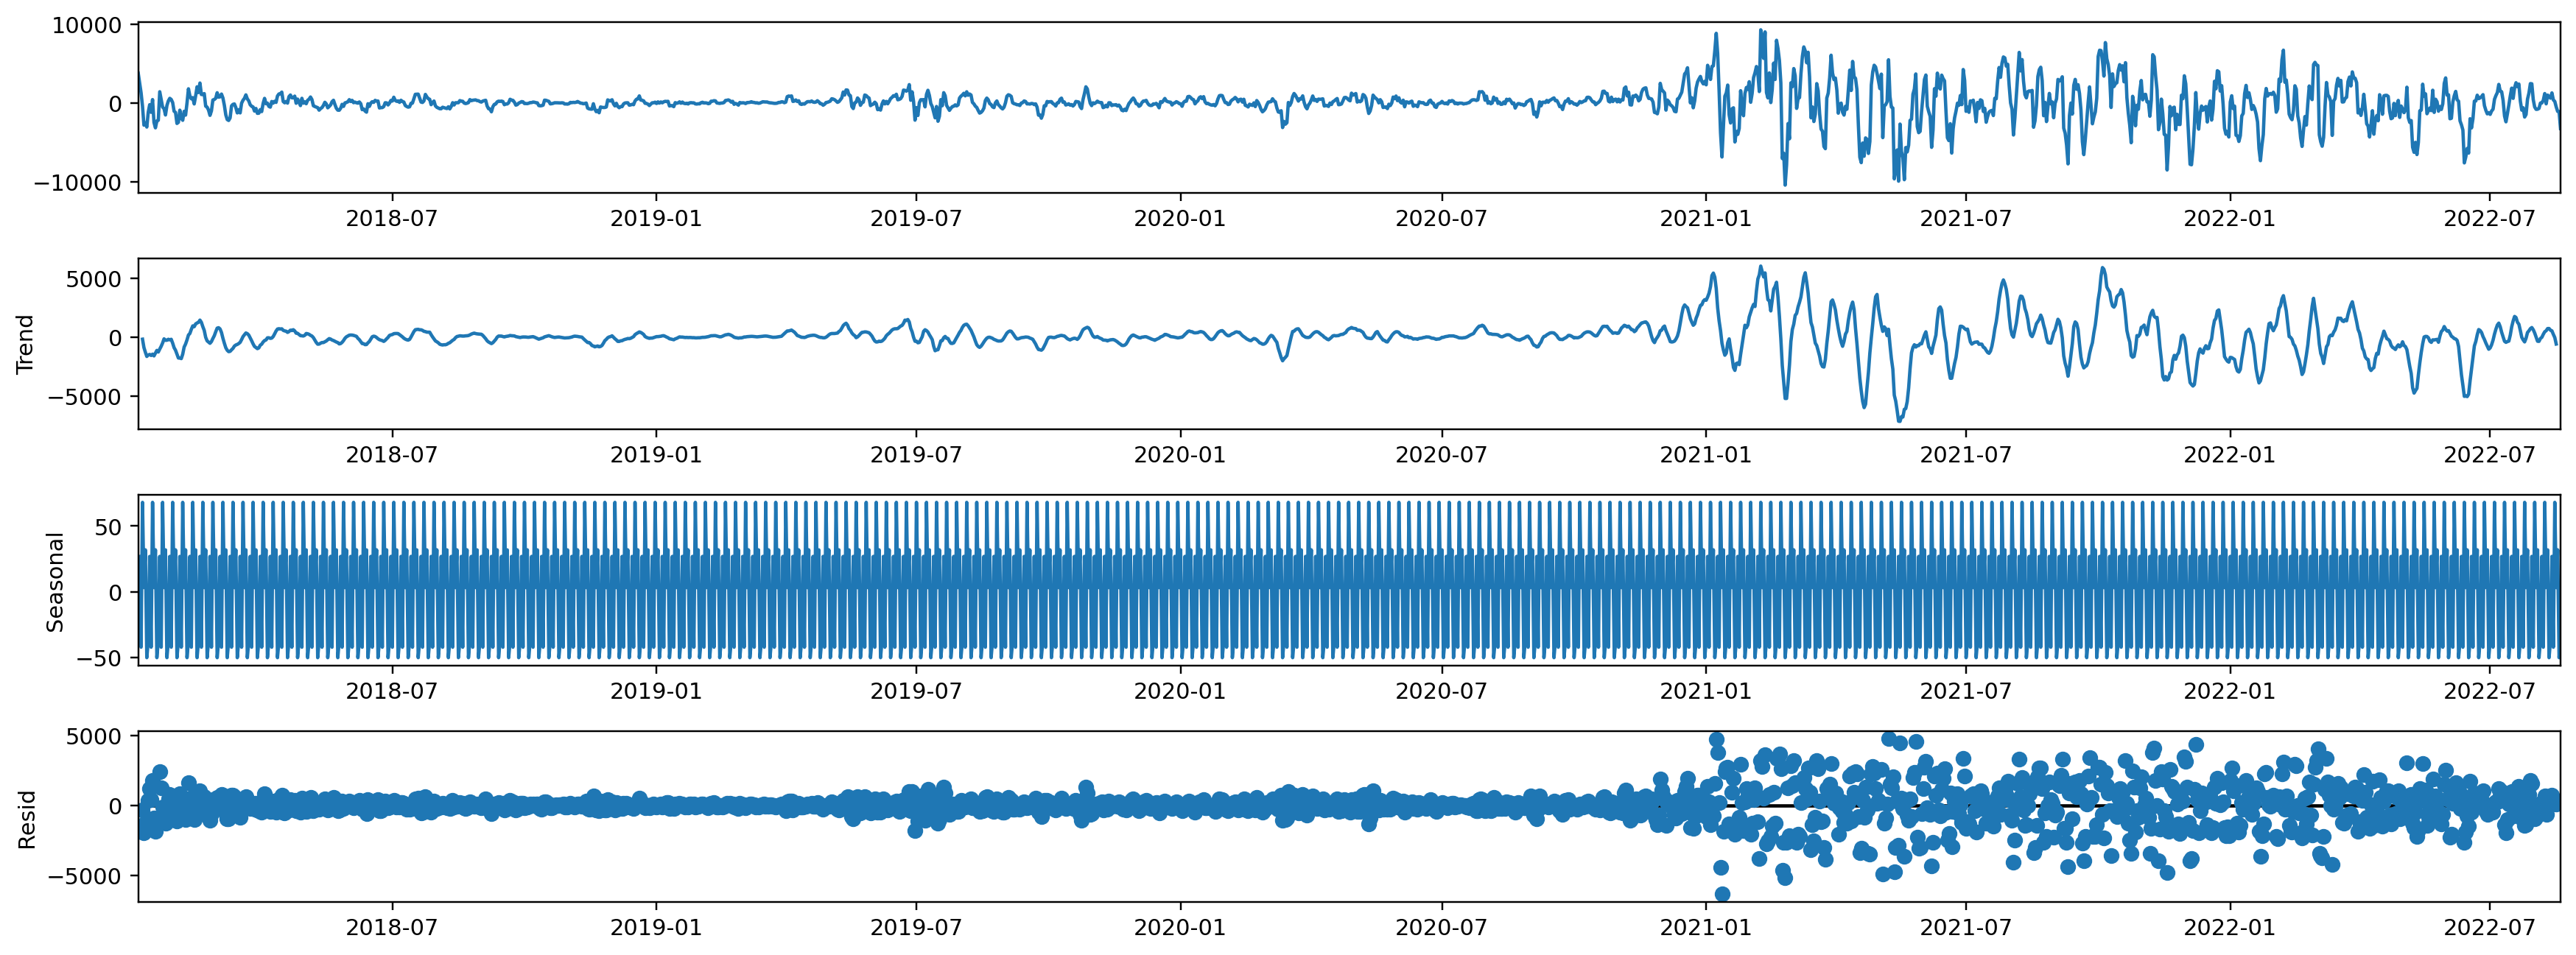

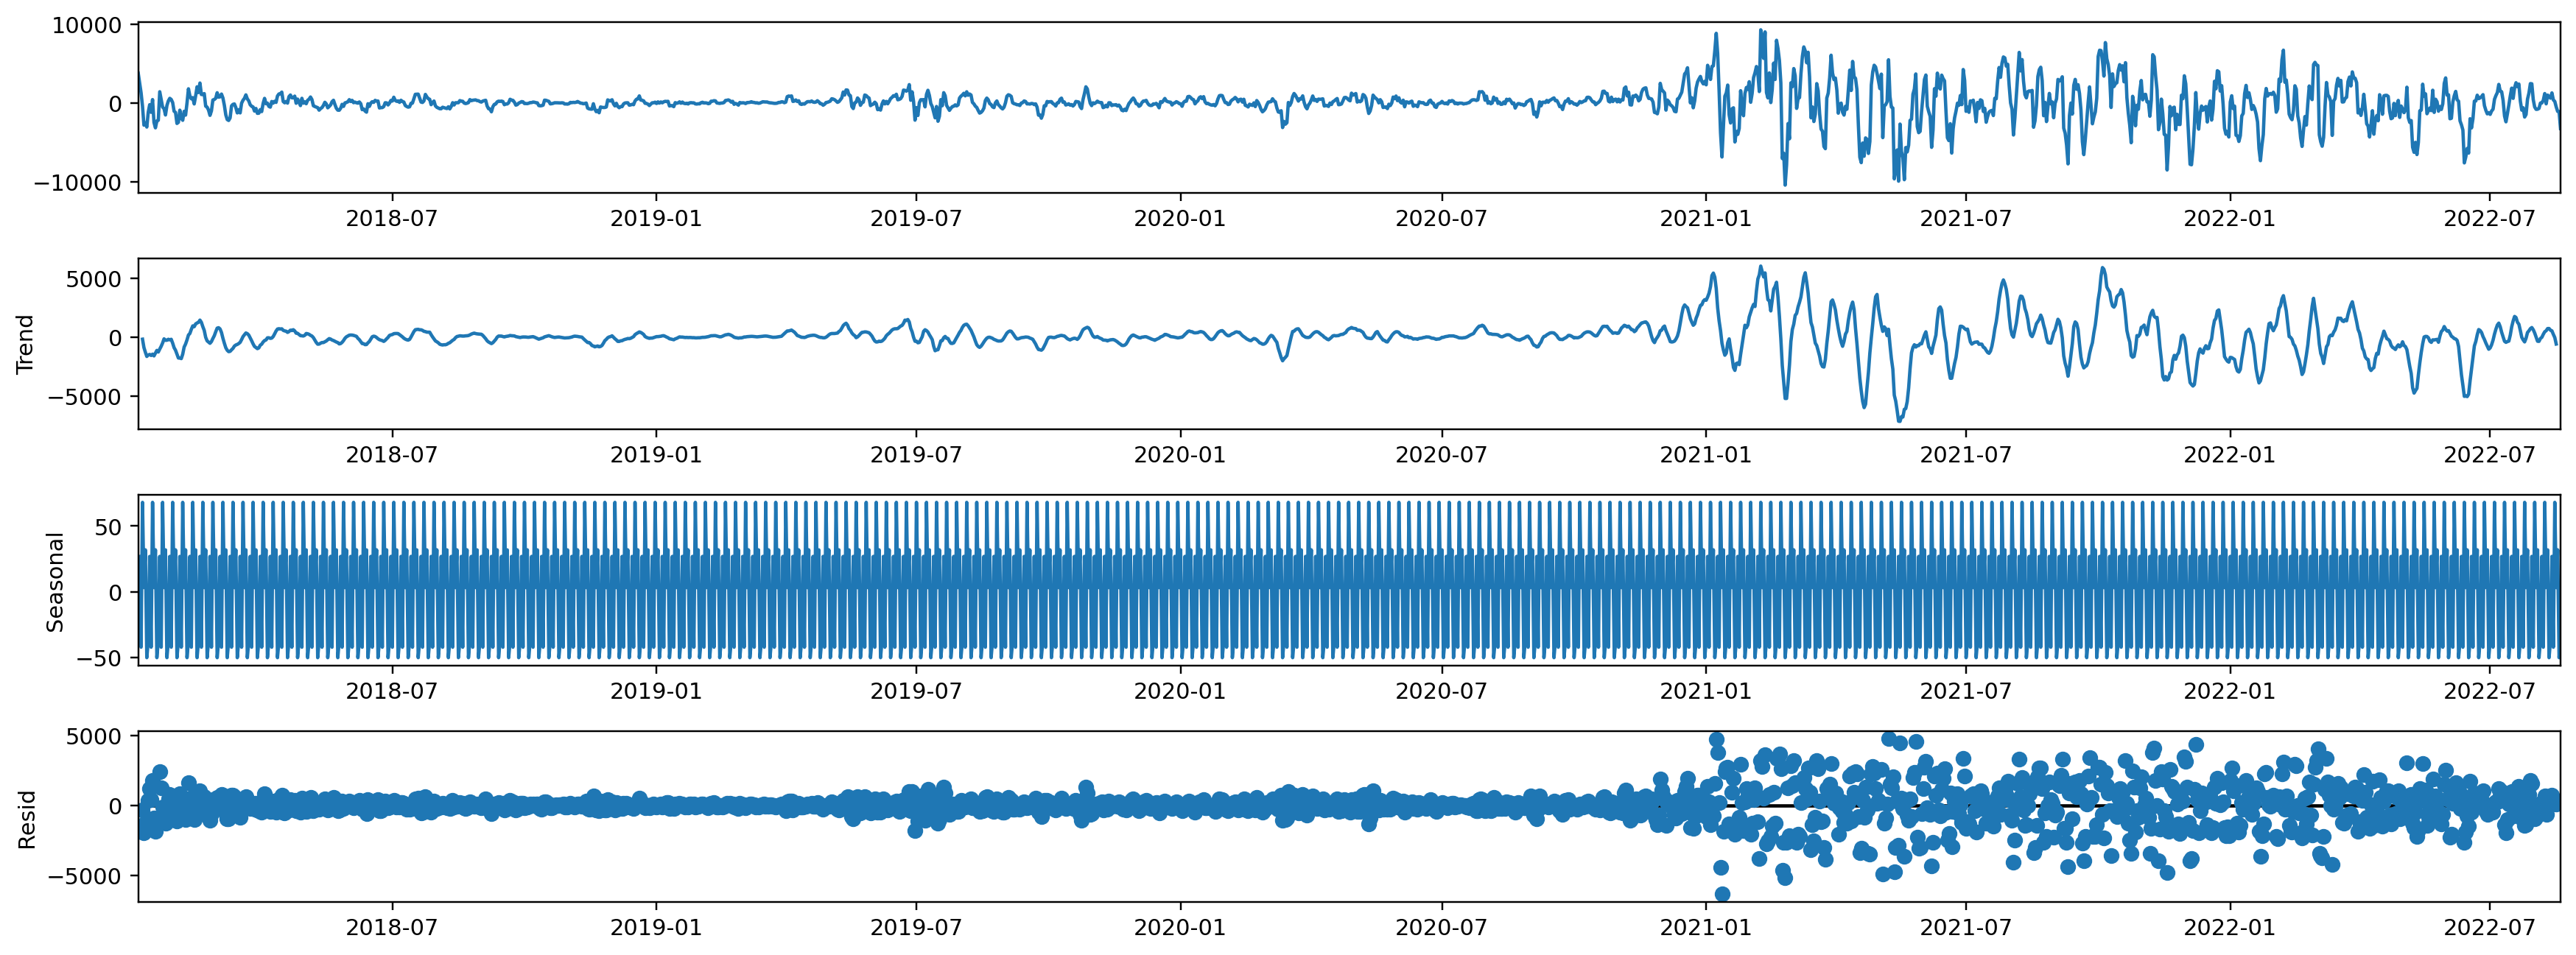

In [13]:
#Checking for Seasonality component
from statsmodels.tsa.seasonal import seasonal_decompose
Dates = pd.date_range('2018-01-01 00:00', periods=len(Y1_Diff), freq='1D')
Y1_Diff.index = Dates
Y1_Diff = Y1_Diff.asfreq('1D')

plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':220})
res = seasonal_decompose(Y1_Diff.dropna())
res.plot()

In [14]:
Y1_Diff

,Close
2018-01-01,NaN
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,3772.299805
...,...
2022-08-15,179.443359
2022-08-16,-519.527344
2022-08-17,-1088.070312
2022-08-18,-1106.595703


In [15]:
#Normalising the Data
from sklearn.preprocessing import MinMaxScaler
Norm = MinMaxScaler() 
Y1_Diff_N = Norm.fit_transform(Y1_Diff)

In [16]:
Y1_Diff_df = pd.DataFrame(Y1_Diff_N, columns = ['Close'])

In [17]:
Y1_Diff_df

,Close
0,NaN
1,NaN
2,NaN
3,NaN
4,0.721142
...,...
1687,0.538916
1688,0.503465
1689,0.474629
1690,0.473690


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1692
Model:                 ARIMA(1, 1, 4)   Log Likelihood                2556.620
Date:                Mon, 19 Sep 2022   AIC                          -5101.240
Time:                        16:16:25   BIC                          -5068.642
Sample:                             0   HQIC                         -5089.169
                               - 1692                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0286      0.016     -1.742      0.081      -0.061       0.004
ma.L1         -0.0013      0.004     -0.321      0.749      -0.009       0.007
ma.L2          0.0005      0.005      0.093      0.9

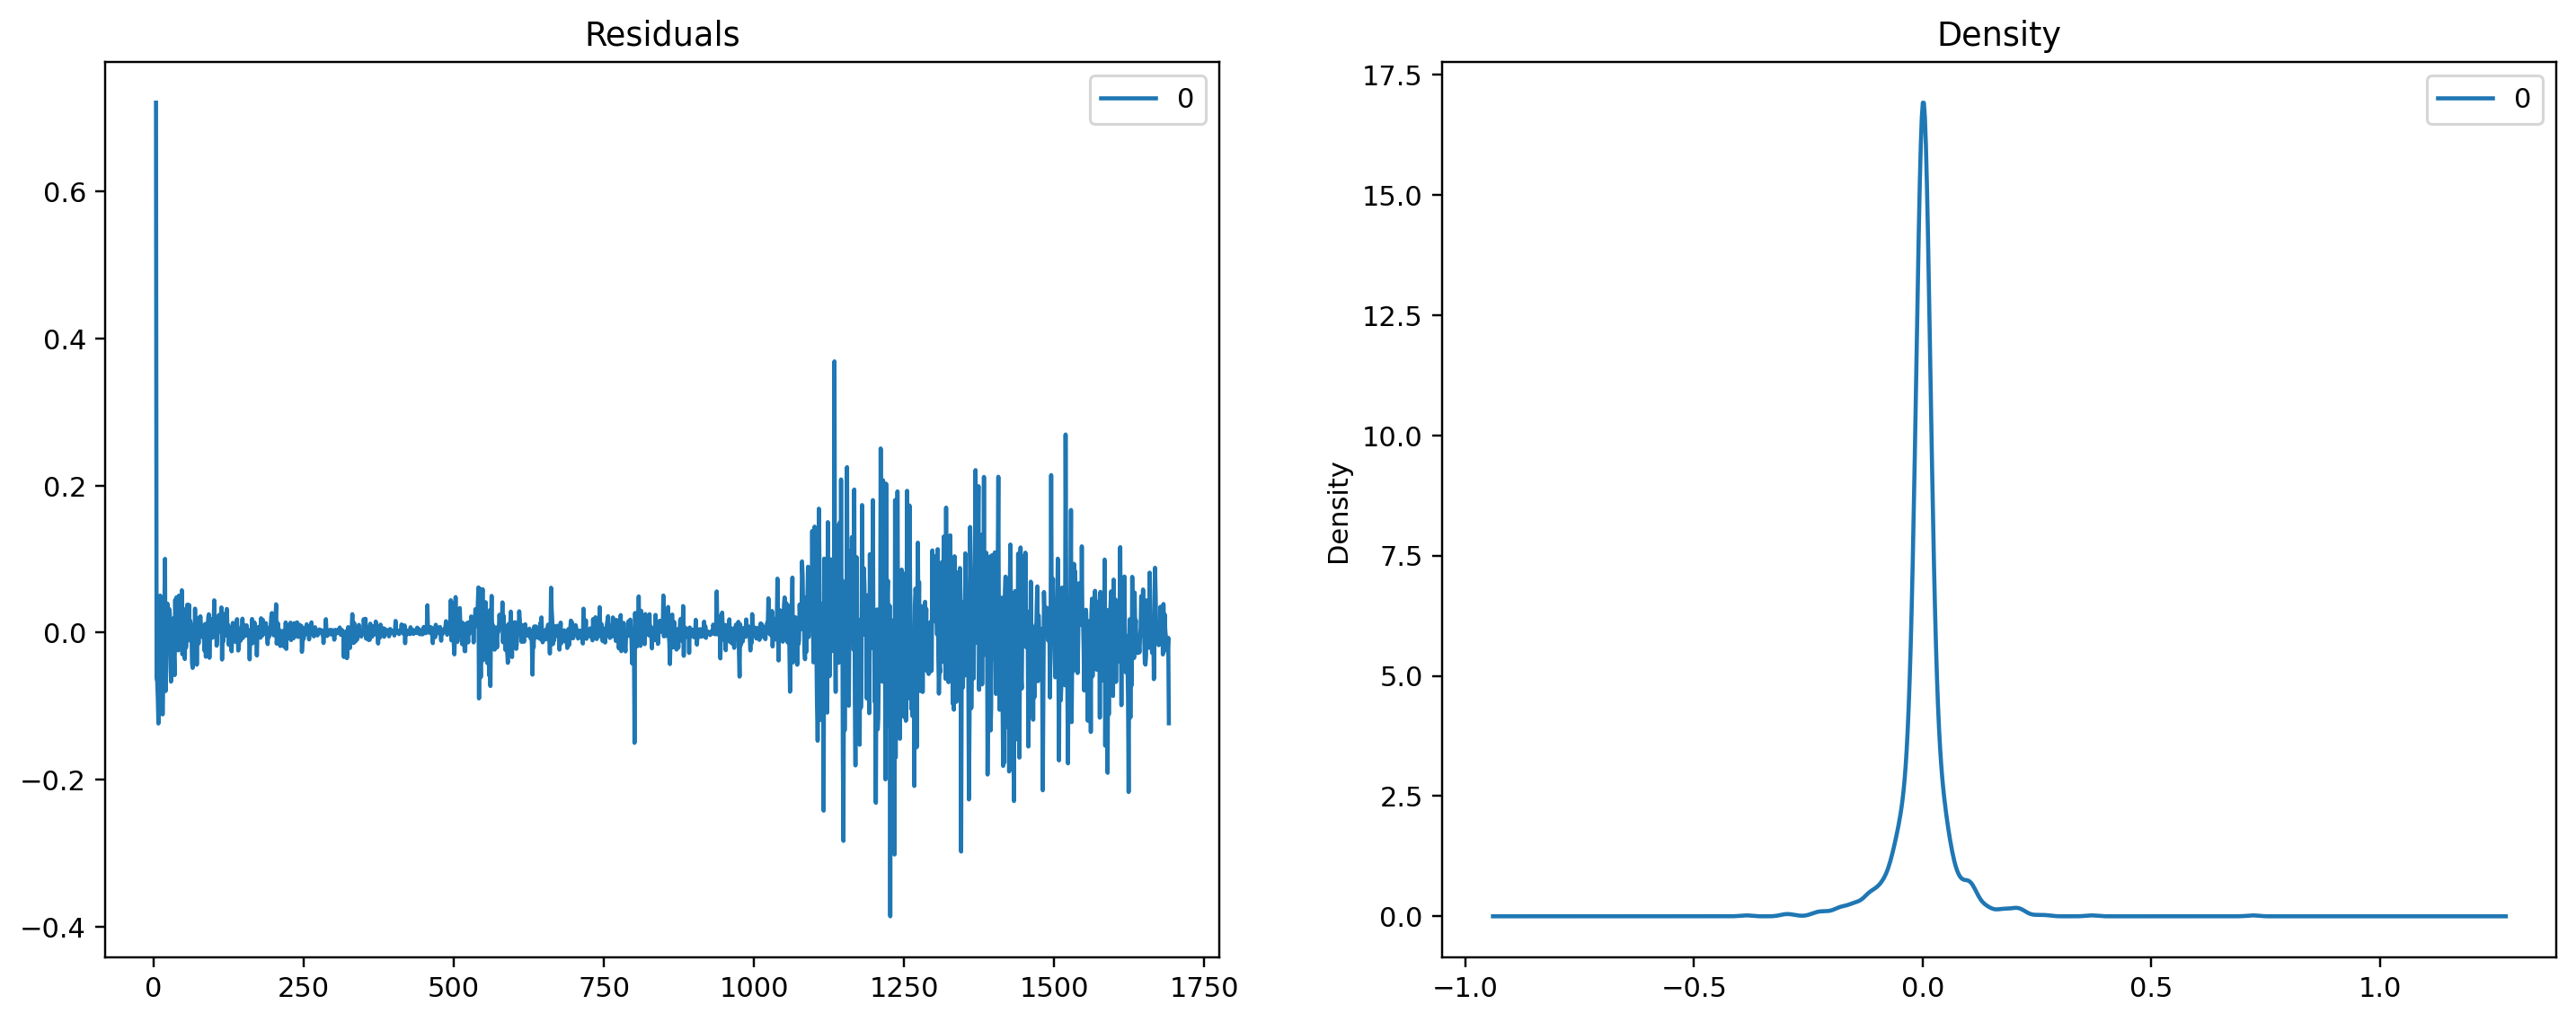

In [18]:
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':220})

# ARIMA Model
model1 = ARIMA(Y1_Diff_df, order=(1,1,4))
model_fit = model1.fit()
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# Actual vs Fitted
YP =  model_fit.predict(0,len(Y1_Diff_df)-1)

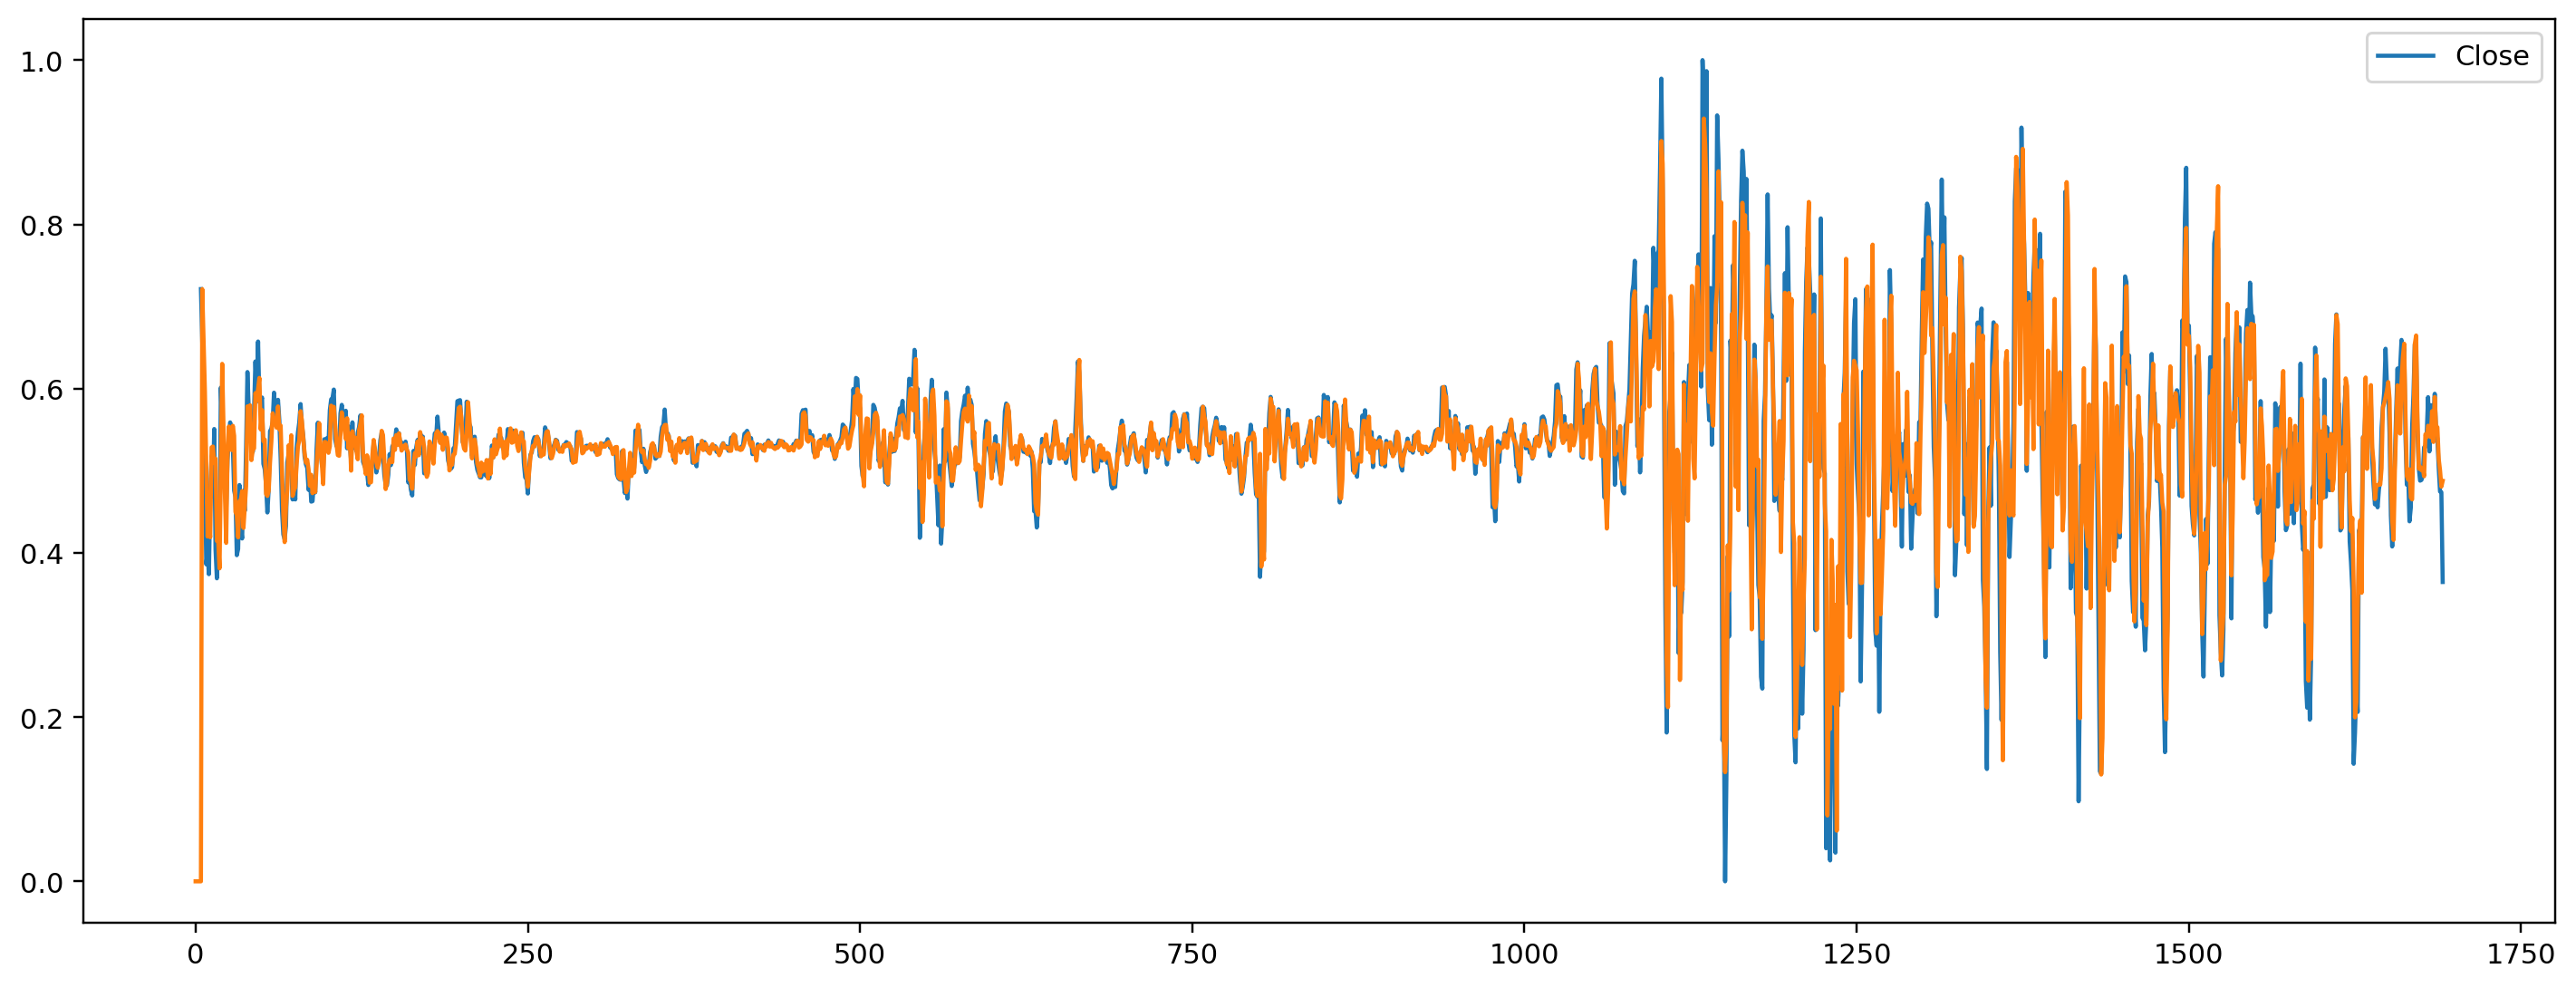

In [19]:
Y1_Diff_df.plot()
YP.plot()

In [20]:
Y1_D = Y1_Diff_df.dropna()
Y1_D

,Close
4,0.721142
5,0.658890
6,0.594563
7,0.508051
8,0.386072
...,...
1687,0.538916
1688,0.503465
1689,0.474629
1690,0.473690


In [21]:
YP

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1687    0.553028
1688    0.514402
1689    0.500528
1690    0.480613
1691    0.487761
Name: predicted_mean, Length: 1692, dtype: float64

In [22]:
YP2 = YP[4:]

In [23]:
YP2

4       0.000000
5       0.721142
6       0.660773
7       0.596541
8       0.509678
          ...   
1687    0.553028
1688    0.514402
1689    0.500528
1690    0.480613
1691    0.487761
Name: predicted_mean, Length: 1688, dtype: float64

In [24]:
YP2.to_frame()

,predicted_mean
4,0.000000
5,0.721142
6,0.660773
7,0.596541
8,0.509678
...,...
1687,0.553028
1688,0.514402
1689,0.500528
1690,0.480613


In [26]:
#Calculating the MSE
print('Mean Squared Error:', metrics.mean_squared_error(Y1_D, YP2))

Mean Squared Error: 0.003095249348156255


In [27]:
#setting the number of days to be predicted
Futuredays = 7

In [28]:
#Normalising the data
Norm = MinMaxScaler() 
y_n = Norm.fit_transform(y)

In [29]:
y_n_df = pd.DataFrame(y_n, columns = ['Close'])

Mean Squared Error: 0.0002781377353623686


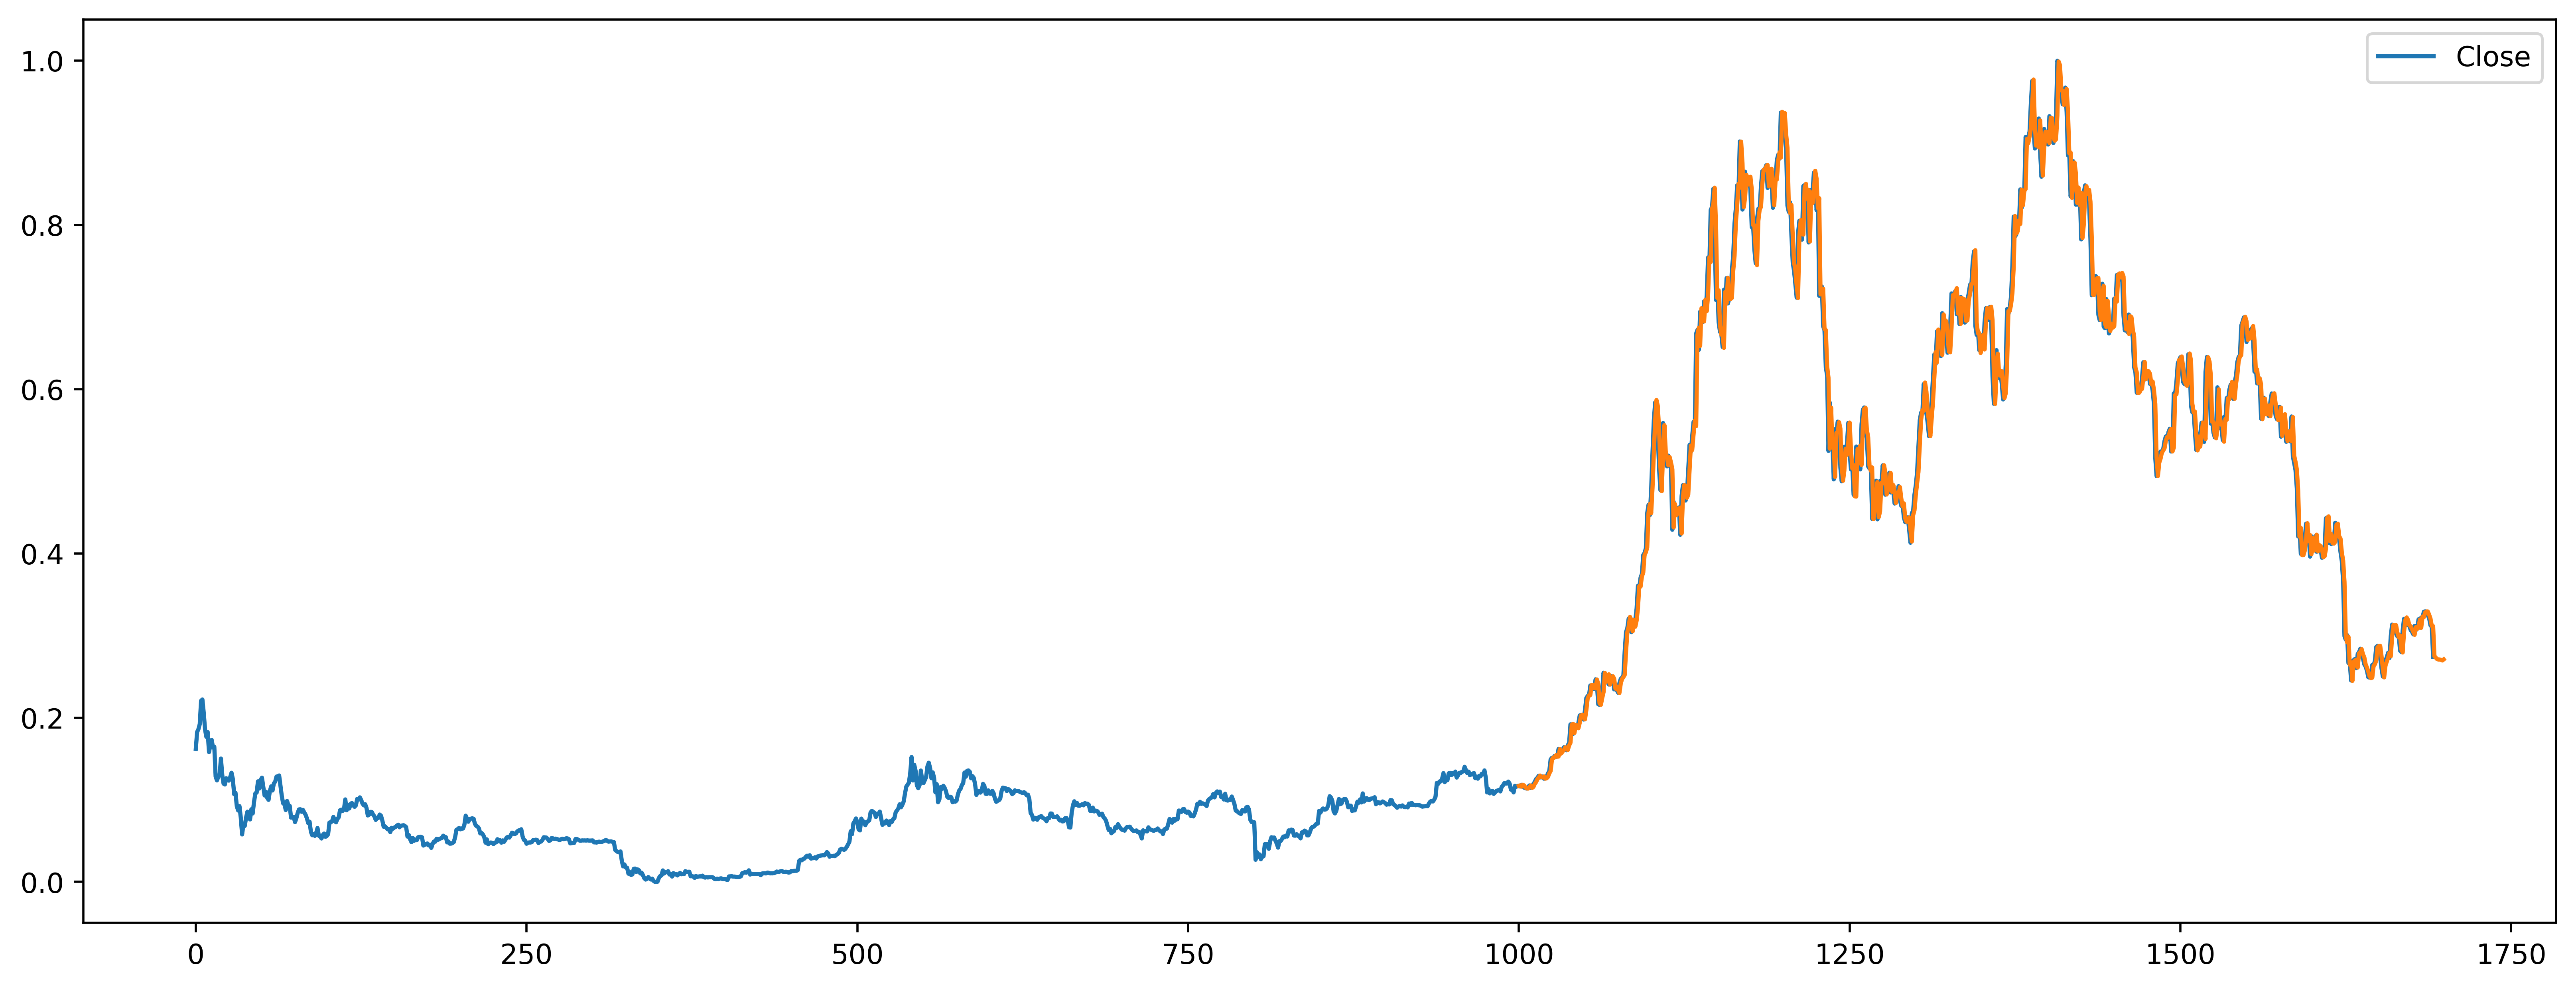

In [31]:
#Sarimax model
plt.rcParams.update({'figure.figsize':(16,6), 'figure.dpi':500})

sarimax = SARIMAX(y_n_df, order=(1, 1, 3), seasonal_order=(1, 1, 3, 4))
sarimax_fit = sarimax.fit(disp=False)
ypred_sarimax = sarimax_fit.predict(0, len(y_n_df)-1)
ypred_sarimax_Future = sarimax_fit.predict(0, len(y_n_df) + int(Futuredays))

print('Mean Squared Error:', metrics.mean_squared_error(y_n_df, ypred_sarimax))

y_n_df.plot()
ypred_sarimax_Future[1000:].plot()


In [37]:
ypred_sarimax_Future

0       0.000000
1       0.161984
2       0.182579
3       0.185982
4       0.273164
          ...   
1695    0.270814
1696    0.270860
1697    0.270380
1698    0.269658
1699    0.270957
Name: predicted_mean, Length: 1700, dtype: float64

In [36]:
#prediction for the next 7 days
for i in range(len(y),len(y)+int(Futuredays)):
  print(Norm.inverse_transform(ypred_sarimax_Future[i].reshape(1,-1)))

[[20912.97920537]]
[[20806.71809945]]
[[20690.66870207]]
[[20658.25064005]]
[[20661.19770265]]
[[20630.32986704]]
[[20583.8498514]]
